# Twitter Airline Sentiment Analysis

## Load Dataset and import libraries

In [40]:
import os, zipfile
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# !pip install kaggle

# Download your kaggle.json file and place it in the path below
os.environ['KAGGLE_CONFIG_DIR'] = "./.kaggle"

!kaggle datasets download -p ./dataset crowdflower/twitter-airline-sentiment

twitter-airline-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile('./dataset/twitter-airline-sentiment.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [13]:
df = pd.read_csv("dataset/Tweets.csv")
print(df.columns)
print(df.shape)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
(14640, 15)


## Basic Data Analysis

In [14]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [15]:
df.describe(include=['object', 'bool'])

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Data preprocess and feature extraction

In [17]:
# nltk.download('stopwords')

In [18]:
df['text'].head(5)

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [19]:
def clean_text(text):

    cleaned_text = text.lower().replace('\n', ' ')
    cleaned_text = re.sub('[^\w\s]', '', cleaned_text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(cleaned_text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])

    return text

In [20]:
df['text'] = df['text'].apply(clean_text)

In [21]:
df['text'].head(5)

0                          virginamerica dhepburn said
1    virginamerica plus youve added commercials exp...
2    virginamerica didnt today must mean need take ...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
Name: text, dtype: object

In [24]:
# Vectorize text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])

In [36]:
# Vectorize target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

print("Mapping of original labels to encoded labels:")
for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(label, ":", encoded_label)


Mapping of original labels to encoded labels:
negative : 0
neutral : 1
positive : 2


## Train a model

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [38]:
# Train a Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [46]:
def test_model(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy: >.6}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=[4,4])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False, linewidths=1,
                xticklabels=['Predicted Negative', 'Predicted Neutral' ,'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Neutral' ,'Actual Positive'])

    plt.title('Confusion Matrix')

    # # Calculate F1 score
    # f1 = f1_score(y_test, y_pred)
    # print(f"F1 Score: {f1: >.6}")

Accuracy: 0.748975


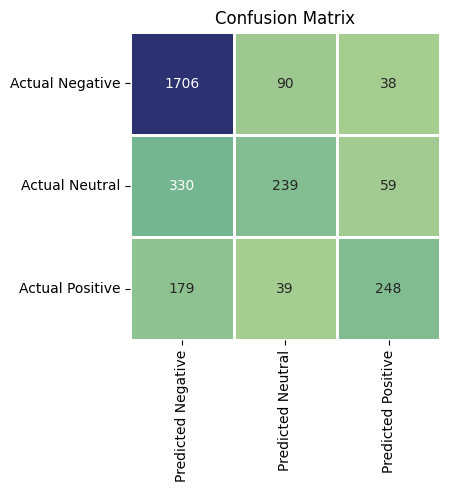

In [47]:
y_pred = model.predict(X_test)
test_model(y_pred, y_test)


In [56]:
pred = pd.DataFrame(y_test)
pred.value_counts()

0    1834
1     628
2     466
Name: count, dtype: int64